## Modules à importer

In [4]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
surveysnl = surveys[0:1]+surveys[2:]

## Définitions des dictionnaires

In [3]:
##############################################################################
############## $z[:z_max]$, $x_1[:z_max]$, data_all, mean et std #############
##############################################################################

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1])
    z_zcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zmax_cuts[survey]]
    x1_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zmax_cuts[survey]]
    c_zcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zmax_cuts[survey]]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])
    
##############################################################################
##################### $[:z_inf]$, $[z_sup:]$ et mean_inf #####################
##############################################################################

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys:
    zinf_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][0])
    z_zinfcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zinf_cuts[survey]]

z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys:
    zsup_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][1])
    z_zsupcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zsup_cuts[survey]]
   
names_sup = []
stretchs_sup = []
stretchs_err_sup = []
colors_sup = []
colors_err_sup = []
redshifts_sup = []

for survey in surveys[1:-1]:
    names_sup += [survey for i in range(len(z_zsupcuts[survey]))] 
    stretchs_sup += list(x1_zsupcuts[survey]) 
    stretchs_err_sup += list(x1_err_zsupcuts[survey]) 
    colors_sup += list(c_zsupcuts[survey]) 
    colors_err_sup += list(c_err_zsupcuts[survey]) 
    redshifts_sup += list(z_zsupcuts[survey]) 

df_sup = pd.DataFrame({'survey': names_sup,
                        'stretchs': stretchs_sup,
                        'stretchs_err': stretchs_err_sup,
                        'colors': colors_sup,
                        'colors_err': colors_err_sup,
                        'redshifts': redshifts_sup})

##############################################################################
########################## $[z_max, inf:z_max, sup]$ #########################
##############################################################################

zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys:
    zbtw_cuts[survey] = np.where((df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][0])
                               & (df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1]))
    z_zbtwcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zbtw_cuts[survey]]

### Plot base model shape

In [4]:
gen = stretchevol.generic()
gen.set_model('Evol3G2M2S')
baseTOT = gen.fit(df_nc)
x_lin = np.linspace(-3, 3, 1000)
pdfmodel_mid = baseTOT.likelihood_tot(baseTOT.delta(0.15),
                                      x_lin, 0, #np.mean(dx1),
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])

In [5]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-lin.txt', x_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-val.txt', pdfmodel_mid)

### Plot asymgaus color shape (PS1)

In [12]:
gen.set_model('Evol1G1M2S')
asym = gen.fit(df_nc)
c_lin = np.linspace(-0.3, 0.3, 1000)
casym = asym.likelihood_tot(c_lin, np.array([0. for i in range(len(c_lin))]),
                            -0.068, 0.034, 0.123)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-lin.txt', c_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-val.txt', casym)

### Plot mass distribution of hostlib

In [3]:
samples = ['lowz', 'found', 'highz']

sm = ipw.Dropdown(options=samples,
                  description='Sample:',
                  value='lowz')

display(sm)

Dropdown(description='Sample:', options=('lowz', 'found', 'highz'), value='lowz')

In [4]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/'+
                      f'BP_{sm.value}.HOSTLIB', skiprows=[0], delim_whitespace=True)

In [5]:
ran_mass = hostlib['LOGMASS']#.sample(100000)

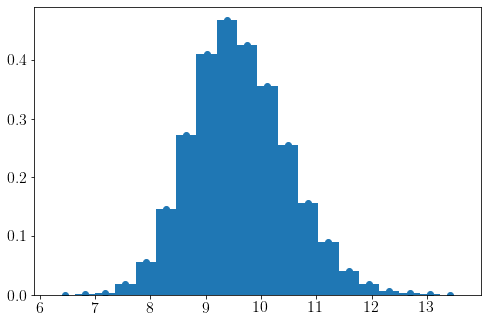

In [17]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histout = ax.hist(ran_mass, bins=20, density=True)
ax.scatter((histout[1][:-1]+histout[1][1:])/2, histout[0])

In [18]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-lin.txt', (histout[1][:-1]+histout[1][1:])/2)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-val.txt', histout[0])

### $\texttt{SALT2.4}$ time series and point band PS1

In [ ]:
sncosmo.